# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 7/15/22
* Student Name: Aubrey Winger
* Student Net ID: alw8ef
* This URL: <a URL to the notebook source of this document>
* GitHub Repo URL: https://github.com/aubrwing/final_project

# The Monte Carlo Module

In [2]:
import pandas as pd
import random
import numpy as np
class Die():
    """
    Purpose: To create a die that has N sides, or “faces”, and W weights, 
    and can be rolled to select a face.
    """
    def __init__(self,faces):
        """
        Input: An array of faces as an argument. 
        The array's data type (dtype) may be strings or numbers.
        Purpose: Instantiates the die object, internally initializes 
        all weights as 1 
        Output: Saves the die object to a private dataframe
        """
        weights = [1.0] * len(faces)
        self.face_list = faces
        self._die = pd.DataFrame({'faces':faces,'weights':weights})
    def change_weight(self,val,weight):
        """
        Input: The face value to be changed and the new weight.
        Purpose: Change the weight of a single side of the die
        Output: Updates a specifc face in the die object with the new weight
        """
        test = self._die[self._die.faces == val]
        if len(test)!=0:
            try:
                weight = float(weight)
                self._die.loc[self._die.faces==val,'weights'] = weight
            except:
                print("Weight must be a number")
        else:
            print("Face is not valid")
            return
    def roll(self,num_time=1):
        """
        Input: Parameter of how many times the die is to be rolled; 
        defaults to 1.
        Purpose: Randomly sample from the vector of faces according to the 
        weights
        Output: A list of outcomes
        """
        return random.choices(self._die.faces,\
                              weights = self._die.weights,k=num_time)
    def show_die(self):
        """
        Input: None
        Purpose: Show the user the die’s current set of faces and weights
        Output: Returns the dataframe created in the initializer
        """
        return(self._die)

class Game():
    """
    Purpose: A game consists of rolling of one or more dice 
    of the same kind one or more times. Each die in a given game 
    has the same number of sides and associated 
    faces, but each die object may have its own weights.
    The class rolls all the dice a given number of times, and stores the 
    results of the most recent game
    """
    def __init__(self,lst):
        """
        Input: a list of Die objects
        Purpose: Instantiate a Game object
        Output: Stores the list of Die objects
        """
        self.lst = lst
    def play(self,num_roll): #issue is here
        """
        Input: Parameter to specify how many times the dice should be rolled
        Purpose: Rolls the dice the specified number of times and saves 
        the result of the play
        Output: A private dataframe of shape N rolls by M dice
        """
        self._results = pd.DataFrame(index=range(1,num_roll+1))
        self._results.index.rename("Roll Number",inplace=True)
        count = 0
        for die in self.lst:
            die_played = die.show_die()
            self._results["Die Result " + str(count)]\
            = die.roll(num_roll)
            count +=1
    def show_play(self,form="wide"):
        """
        Input: Parameter to return the dataframe in narrow or wide form.
        Defaults to wide form
        Purpose: Show the user the results of the most recent play
        Output: The private dataframe recording the game results
        """
        if form.lower()=='wide':
            return self._results
        elif form.lower()=='narrow':
            self._results_narrow = self._results.reset_index()
            return pd.wide_to_long(self._results_narrow,\
            stubnames='Die Result ',i = ['Roll Number'], j='Die Number')
        else:
            print("Form must be wide or narrow")
            return

class Analyzer():
    """
    Purpose: An analyzer takes the results of a single game and computes 
    various descriptive statistical properties about it. 
    These properties results are available as attributes of an Analyzer object.
    """
    def __init__(self, game):
        """
        Input: A game object
        Purpose: Initializes the Analyzer object
        Output: Stores the game object and the last recorded play
        """
        self.game_results = game.show_play('wide')
        self.game = game
    def jackpot(self):
        """
        Input: None
        Purpose: Computes how many times the game resulted in all 
        faces being identical. 
        Output: Stores the jackpot results in a public attribute.
        Returns an integer for the number of times to the user.
        """
        count = 0
        self.jackpot_results = pd.DataFrame(index=range(1,\
                                len(self.game_results)\
                                +1),columns=["Jackpot"])
        self.jackpot_results.index.rename("Roll Number",inplace=True)
        for i in range(1,len(self.game_results)+1):
            test = self.game_results.loc[i]
            counts = test.value_counts().tolist()
            if counts[0]==len(test): #compare results across n die
                self.jackpot_results.Jackpot[i] = True
                count += 1
            else:
                self.jackpot_results.Jackpot[i] = False 
            
        return count
    def combo(self):
        """
        Input: None
        Purpose: Compute the distinct combinations of faces rolled, 
        along with their counts
        Output: Sorts and stores the combinations as a dataframe in a
        public attribute.
        """
        self.combo_results = self.game_results.apply\
        (lambda x: pd.Series(sorted(x)), 1)\
         .value_counts()\
         .to_frame('n')
    def face_counts_per_roll(self):
        """
        Input: None
        Purpose: Compute how many times a given face is rolled in each event
        Output: Stores the results as a dataframe in a public attribute.
        """
        self.face_counts = pd.DataFrame(index=range(1,len(self.game_results)+1))
        self.face_counts.index.rename("Roll Number",inplace=True)        
        #makes a labeled dataframe of all zeros
        for i in self.game.lst[0].face_list:
            self.face_counts['Face ' + str(i)] = np.zeros(len(self.game_results))
        for index, row in self.game_results.iterrows():
            for entry in self.game_results.loc[index]:
                self.face_counts.loc[index,'Face ' + str(entry)] += 1

# Test Module

In [3]:
import unittest
import pandas as pd

class MontecarloTestSuite(unittest.TestCase):
    def test_1_change_weight(self):
        """
        Tests the change_weight() method in the Die class by
        checking if the die weights stored are correct
        """
        myDie = Die([1,2,3,4,5])
        myDie.change_weight(1,15)
        test = [15,1,1,1,1]
        equality_test = myDie._die.weights == test
        self.assertTrue(equality_test.all())
    def test_2_roll(self):
        """
        Tests the roll() method in the Die class by checking
        if the results from the roll are included the faces parameter
        """
        myDie = Die([1,2,3,4,5])
        test = myDie.roll(3)
        truth_test = [i for i in test if i in [1,2,3,4,5]]
        self.assertEqual(test,truth_test)
    def test_3_show_die(self):
        """
        Test the show_die() method in the Die class by checking
        if the die stored is the same as one created without using the Die class
        """
        myDie = Die([1,2,5,8,10])
        fakeDie = pd.DataFrame({'faces':[1,2,5,8,10],'weights':[1,1,1,1,1]})
        equality_test = myDie.show_die() == fakeDie
        self.assertTrue(equality_test.all().all())
    def test_4_play(self):import unittest

class MontecarloTestSuite(unittest.TestCase):
    def test_1_change_weight(self):
        """
        Tests the change_weight() method in the Die class by
        checking if the die weights stored are correct
        """
        myDie = Die([1,2,3,4,5])
        myDie.change_weight(1,15)
        test = [15,1,1,1,1]
        equality_test = myDie._die.weights == test
        self.assertTrue(equality_test.all())
    def test_2_roll(self):
        """
        Tests the roll() method in the Die class by checking
        if the results from the roll are included the faces parameter
        """
        myDie = Die([1,2,3,4,5])
        test = myDie.roll(3)
        truth_test = [i for i in test if i in [1,2,3,4,5]]
        self.assertEqual(test,truth_test)
    def test_3_show_die(self):
        """
        Test the show_die() method in the Die class by checking
        if the die stored is the same as one created without using the Die class
        """
        myDie = Die([1,2,5,8,10])
        fakeDie = pd.DataFrame({'faces':[1,2,5,8,10],'weights':[1,1,1,1,1]})
        equality_test = myDie.show_die() == fakeDie
        self.assertTrue(equality_test.all().all())
    def test_4_play(self):
        """
        Test the the play() method in the Game class to see if it returns 5 rolls
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        self.assertEqual(len(myGame._results),5)
    def test_5_show_play(self):
        """
        Test the show_play() method in the Game class to see if 
        the narrow form is formatted correctly
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(10)
        test = myGame.show_play("narrow")
        self.assertEqual(len(test),20)
    def test_6_jackpot(self):
        """
        Test the jackpot() method in the Analyzer class to 
        see if the return value is equal to 
        the sum of 'True' entries in the jackpot dataframe
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        myAnalyzer = Analyzer(myGame)
        count = myAnalyzer.jackpot()
        test = myAnalyzer.jackpot_results.Jackpot.sum()
        self.assertEqual(test,count)
    def test_7_combo(self):
        """
        Test the combo() function in the Analyzer class by
        comparing the sum of the combinations found to the number of 
        games played
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        myAnalyzer = Analyzer(myGame)
        myAnalyzer.combo()
        test = sum(myAnalyzer.combo_results.n)
        self.assertEqual(test,5)
    def test_8_face_counts_per_roll(self):
        """
        Test the face_counts_per_roll() function by checking
        if the value_counts stored in game_results were the same as the
        ones generated by face_counts_per_roll
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        myAnalyzer = Analyzer(myGame)
        myAnalyzer.face_counts_per_roll()
        test = myAnalyzer.face_counts
        valueDie0 = myAnalyzer.game_results['Die Result 0'].value_counts()
        valueDie1 = myAnalyzer.game_results['Die Result 1'].value_counts()
        new_thing = valueDie0.add(valueDie1,fill_value=0)
        testsum = test.sum(axis=0)
        testsum = testsum.loc[(testsum != 0)]
        testsum = testsum.reset_index(drop=True)
        new_thing = new_thing.reset_index(drop=True)
        equality=(new_thing==testsum).all()
        self.assertTrue(equality)
        
        
    
        """
        Test the the play() method in the Game class to see if it returns 5 rolls
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        self.assertEqual(len(myGame._results),5)
    def test_5_show_play(self):
        """
        Test the show_play() method in the Game class to see if 
        the narrow form is formatted correctly
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(10)
        test = myGame.show_play("narrow")
        self.assertEqual(len(test),20)
    def test_6_jackpot(self):
        """
        Test the jackpot() method in the Analyzer class to 
        see if the return value is equal to 
        the sum of 'True' entries in the jackpot dataframe
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        myAnalyzer = Analyzer(myGame)
        count = myAnalyzer.jackpot()
        test = myAnalyzer.jackpot_results.Jackpot.sum()
        self.assertEqual(test,count)
    def test_7_combo(self):
        """
        Test the combo() function in the Analyzer class by
        comparing the sum of the combinations found to the number of 
        games played
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        myAnalyzer = Analyzer(myGame)
        myAnalyzer.combo()
        test = sum(myAnalyzer.combo_results.n)
        self.assertEqual(test,5)
    def test_8_face_counts_per_roll(self):
        """
        Test the face_counts_per_roll() function by checking
        if the value_counts stored in game_results were the same as the
        ones generated by face_counts_per_roll
        """
        myDie = Die([1,2,3,4,6])
        myDie2 = Die([1,2,3,4,6])
        myGame = Game([myDie,myDie2])
        myGame.play(5)
        myAnalyzer = Analyzer(myGame)
        myAnalyzer.face_counts_per_roll()
        test = myAnalyzer.face_counts
        valueDie0 = myAnalyzer.game_results['Die Result 0'].value_counts()
        valueDie1 = myAnalyzer.game_results['Die Result 1'].value_counts()
        new_thing = valueDie0.add(valueDie1,fill_value=0)
        testsum = test.sum(axis=0)
        testsum = testsum.loc[(testsum != 0)]
        testsum = testsum.reset_index(drop=True)
        new_thing = new_thing.reset_index(drop=True)
        equality=(new_thing==testsum).all()
        self.assertTrue(equality)

# Test Results

test_1_change_weight (__main__.MontecarloTestSuite)
Tests the change_weight() method in the Die class by ... ok
test_2_roll (__main__.MontecarloTestSuite)
Tests the roll() method in the Die class by checking ... ok
test_3_show_die (__main__.MontecarloTestSuite)
Test the show_die() method in the Die class by checking ... ok
test_4_play (__main__.MontecarloTestSuite)
Test the the play() method in the Game class to see if it returns 5 rolls ... ok
test_5_show_play (__main__.MontecarloTestSuite)
Test the show_play() method in the Game class to see if ... ok
test_6_jackpot (__main__.MontecarloTestSuite)
Test the jackpot() method in the Analyzer class to ... ok
test_7_combo (__main__.MontecarloTestSuite)
Test the combo() function in the Analyzer class by ... ok
test_8_face_counts_per_roll (__main__.MontecarloTestSuite)
Test the face_counts_per_roll() function by checking ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.027s

OK


# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

This is the Montecarlo module, which includes the classes Die, Game, and analyzer


Text(0.5, 1.0, 'Jackpot Results')

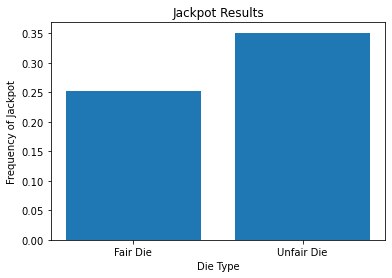

In [4]:
import matplotlib.pyplot as plt
from montecarlo.montecarlo import Die
from montecarlo.montecarlo import Game
from montecarlo.montecarlo import Analyzer
fair_coin = Die(['H','T'])
unfair_coin = Die(['H','T'])
unfair_coin.change_weight('H',5)
myGame = Game([fair_coin,fair_coin,fair_coin])
myGame.play(1000)
myGame2 = Game([fair_coin,unfair_coin,unfair_coin])
myGame2.play(1000)
myAnalyzer = Analyzer(myGame)
fair_jackpot = myAnalyzer.jackpot()
myAnalyzer2 = Analyzer(myGame2)
unfair_jackpot = myAnalyzer2.jackpot()
plt.bar(['Fair Die','Unfair Die'],[fair_jackpot/1000,unfair_jackpot/1000])
plt.xlabel('Die Type')
plt.ylabel('Frequency of Jackpot')
plt.title("Jackpot Results")

## Scenario 2

Text(0.5, 1.0, 'Jackpot Results')

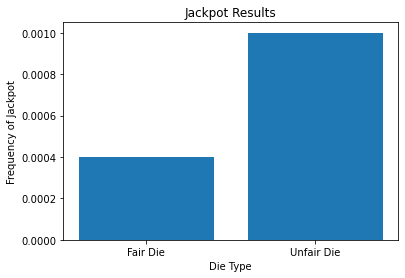

In [5]:
fair_die = Die([1,2,3,4,5,6])
unfair_die1 = Die([1,2,3,4,5,6])
unfair_die2 = Die([1,2,3,4,5,6])
unfair_die1.change_weight(6,5)
unfair_die2.change_weight(1,5)
myGame = Game([fair_die,fair_die,fair_die,fair_die,fair_die])
myGame.play(10000)
myGame2 = Game([fair_die, fair_die, unfair_die1, unfair_die1, unfair_die2])
myGame2.play(10000)
myAnalyzer3 = Analyzer(myGame)
myAnalyzer4 = Analyzer(myGame2)
fairJackpot3 = myAnalyzer3.jackpot()
unfairJackpot4 = myAnalyzer4.jackpot()
plt.bar(['Fair Die','Unfair Die'],[fairJackpot3/10000,unfairJackpot4/10000])
plt.xlabel('Die Type')
plt.ylabel('Frequency of Jackpot')
plt.title("Jackpot Results")

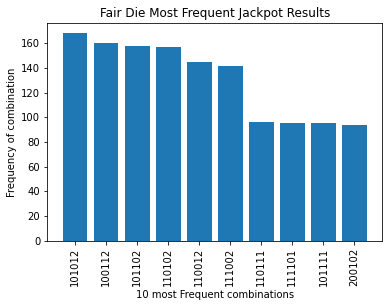

In [26]:
myAnalyzer3.face_counts_per_roll()
myAnalyzer4.face_counts_per_roll()
counts3 = myAnalyzer3.face_counts.value_counts().tolist()
counts4 = myAnalyzer4.face_counts.value_counts().tolist()
combo = myAnalyzer4.face_counts.value_counts().index.tolist()[0:10]
count = 0
count2 = 0
for i in combo:
    lst = []
    for j in i:
        lst.append(str(int(j)))
        count2 += 1
    combo[count] = lst
    count += 1
strCombo = [''.join(x) for x in combo]
plt.bar(strCombo, counts3[0:10])
plt.xlabel('10 most Frequent combinations')
plt.ylabel('Frequency of combination')
plt.title("Fair Die Most Frequent Jackpot Results")
plt.xticks(rotation=90)
plt.show()

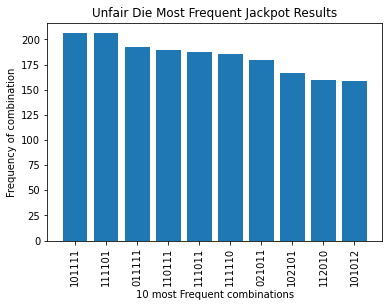

In [25]:
combo = myAnalyzer3.face_counts.value_counts().index.tolist()[0:10]
count = 0
count2 = 0
for i in combo:
    lst = []
    for j in i:
        lst.append(str(int(j)))
        count2 += 1
    combo[count] = lst
    count += 1
strCombo = [''.join(x) for x in combo]
plt.bar(strCombo, counts4[0:10])
plt.xlabel('10 most Frequent combinations')
plt.ylabel('Frequency of combination')
plt.title("Unfair Die Most Frequent Jackpot Results")
plt.xticks(rotation=90)
plt.show()

## Scenario 3

In [8]:
letter_die = Die(['A','B','C','D','E','F','G','H','I','J','K','L','M','N',
                  'O','P','Q','R','S','T','U','V','W','X','Y','Z'])
letter_die.change_weight('A',8.4966)
letter_die.change_weight('B',2.0720)
letter_die.change_weight('C',4.5388)
letter_die.change_weight('D',3.3844)
letter_die.change_weight('E',11.1607)
letter_die.change_weight('F',1.8121)
letter_die.change_weight('G',2.4705)
letter_die.change_weight('H',3.0034)
letter_die.change_weight('I',7.5448)
letter_die.change_weight('J',0.1965)
letter_die.change_weight('K',1.1016)
letter_die.change_weight('L',5.4893)
letter_die.change_weight('M',3.0129)
letter_die.change_weight('N',6.6544)
letter_die.change_weight('O',7.1635)
letter_die.change_weight('P',3.1671)
letter_die.change_weight('Q',0.1962)
letter_die.change_weight('R',7.5809)
letter_die.change_weight('S',5.7351)
letter_die.change_weight('T',6.9509)
letter_die.change_weight('U',3.6308)
letter_die.change_weight('V',1.0074)
letter_die.change_weight('W',1.2899)
letter_die.change_weight('X',0.2902)
letter_die.change_weight('Y',1.7779)
letter_die.change_weight('Z',0.2722)
myGameLetter = Game([letter_die,letter_die,letter_die,letter_die,letter_die])
myGameLetter.play(1000)
words = myGameLetter.show_play()
#pd.set_option('display.max_rows', None)
words

,Die Result 0,Die Result 1,Die Result 2,Die Result 3,Die Result 4
Roll Number,,,,,
1,E,D,I,E,N
2,K,R,C,D,W
3,T,E,D,B,E
4,E,E,R,O,N
5,I,W,E,N,O
...,...,...,...,...,...
996,R,S,L,I,I
997,N,K,O,Z,B
998,W,R,A,A,A


# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [9]:
!ls -lRF -o

total 136
-rw-rw-r--@  1 aubrey  63913 Jul 15 17:27 FinalProjectSubmissionTemplate.ipynb
drwxr-xr-x  10 aubrey    320 Jul 15 17:02 montecarlo/
drwxr-xr-x   6 aubrey    192 Jul 15 12:06 montecarlo.egg-info/
-rw-r--r--@  1 aubrey    374 Jul 15 10:10 setup.py

./montecarlo:
total 56
-rw-r--r--@ 1 aubrey    90 Jul 15 10:13 __init__.py
drwxr-xr-x  4 aubrey   128 Jul 15 17:14 __pycache__/
-rw-r--r--  1 aubrey  6420 Jul 15 17:02 montecarlo.py
-rw-r--r--@ 1 aubrey  7855 Jul 15 12:08 montecarlo_demo.ipynb
-rw-r--r--@ 1 aubrey   983 Jul 15 10:43 montecarlo_results.txt
-rw-r--r--@ 1 aubrey  3997 Jul 15 10:43 montecarlo_tests.py

./montecarlo/__pycache__:
total 24
-rw-r--r--  1 aubrey   249 Jul 15 12:22 __init__.cpython-39.pyc
-rw-r--r--  1 aubrey  6912 Jul 15 17:14 montecarlo.cpython-39.pyc

./montecarlo.egg-info:
total 32
-rw-r--r--  1 aubrey  310 Jul 15 12:06 PKG-INFO
-rw-r--r--  1 aubrey  223 Jul 15 12:06 SOURCES.txt
-rw-r--r--  1 aubrey    1 Jul 15 12:06 dependency_links.txt
-rw-r--r--  1 aub

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [ ]:
# Installation commands

In [10]:
pip install -e .

Obtaining file:///Users/aubrey/Desktop/montecarlo_package
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 0.1
    Uninstalling montecarlo-0.1:
      Successfully uninstalled montecarlo-0.1
  Running setup.py develop for montecarlo
Note: you may need to restart the kernel to use updated packages.
